In [1]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import one_hot

import torchvision
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize

from matplotlib import pyplot as plt
import random


from InformationPlane import MatrixBasedRenyisEntropy, RKHSMatrixOptimizer
from models.Paper import CNN

### Load MNIST dataset

In [3]:
transformToTensor = Compose([ ToTensor(), Normalize((0.1307,), (0.3081,))])

transformToImage = Compose([  Normalize((-0.1307/0.3081,), (1/0.3081,)), ToPILImage()])

dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)

dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)

### Preparing test


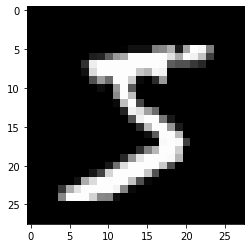

In [7]:
for input, label in dataloader:
    plt.imshow(transformToImage(input[0]), cmap="gray")
    plt.show()
    label = one_hot(label).float()
    # print(label)
    break

model = CNN()
layer = model.conv_layers[0]

input_kernel_matrix = MatrixBasedRenyisEntropy.tensorRBFMatrix(input.flatten(1), 8)

label_kernel_matrix = MatrixBasedRenyisEntropy.tensorRBFMatrix(label, 0.1)

### Information plane test

In [20]:
optimizer = RKHSMatrixOptimizer(label_kernel_matrix)



print(layer(input).shape)




torch.Size([10, 4, 26, 26])


In [11]:
optimizer = RKHSMatrixOptimizer(label_kernel_matrix)


In [10]:
for idx in range(0, 11, 5):
    print(idx)

0
5
10


In [17]:
label[6:10].shape

torch.Size([2, 10])